In [1]:
import numpy as np
from solcore.state import State
import mpld3
from matplotlib import pyplot as plt, cm, ticker
# from material_of_InSb_GaSb import *
from material_and_layer_QD import *
from lib_save_file import *
from solcore.solar_cell_solver import solar_cell_solver
import time
from constant import *

# vint = np.linspace(-3, 3, 600)
# V = np.linspace(-1.5, 0, 300)  # np

# wl = np.linspace(350, 3000, 1001) * 1e-9  # version1
# light_source = LightSource(source_type="standard"
#                            , version="AM1.5g"
#                            , x=wl
#                            , output_units="photon_flux_per_m"
#                            , concentration=1
#                            )
data_solar_cell = dict(
    T=None,
    absorbed=None,
    short_circuit_data=None,
    pdd_data=None,
    recombination_currents=None,
    equilibrium_data=None,
    iv=None,
    qe=None,
    offset=0,
    note='note',
    list_structure=[],
    x_axis=[],
    x_axis_name='None',
    mode='None',
)


def get_color(number_of_color, darkness=0.5):
    cmap = plt.get_cmap('RdYlBu')
    colors = [cmap(i / number_of_color) for i in range(number_of_color)]

    # Darken the colors
    darkened_colors = [(darkness * r, darkness * g, darkness * b, a) for r, g, b, a in colors]

    return darkened_colors
def defultsaveing(solarcell, saveaddrest, version, save=True):
    saveaddrest["T"] = solarcell.T
    saveaddrest['absorbed'] = solarcell.absorbed
    saveaddrest['short_circuit_data'] = solarcell[0].short_circuit_data.copy()
    saveaddrest['pdd_data'] = solarcell[0].pdd_data.copy()
    saveaddrest['recombination_currents'] = solarcell[0].recombination_currents.copy()
    saveaddrest['equilibrium_data'] = solarcell[0].equilibrium_data.copy()
    saveaddrest['iv'] = solarcell.iv.copy()
    saveaddrest['offset'] = solarcell[0].offset
    saveaddrest['qe'] = solarcell[0].qe.copy()
    if save:
        with open(f'{version}.pkl', 'wb') as fin:
            pickle.dump(saveaddrest, fin)
            print('dictionary saved successfully to file')
    return saveaddrest


def load_old_data(version):
    with open(f'{version}', 'rb') as fp:
        data = pickle.load(fp)
    print('Loading dictionary complete')
    # print(data["allI"])
    return data


def save_set_of_data_sun_constant(set_of_data, version, focus_area=None):
    if focus_area is None:
        focus_area = (50, 650)
    simpifly = None
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
    fig_5, ax1_5 = plt.subplots(1, 1, figsize=(12, 8))
    fig1, axes = plt.subplots(2, 2, figsize=(11.25, 8))
    fig2, axIV = plt.subplots(1, 1, figsize=(8, 6))
    # fig2_5, axJ = plt.subplots(1, 1, figsize=(8, 6))
    fig3, axCar = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    fig3_5, axCar2 = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    fig_b1, band1 = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    fig_b2, band2 = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    if len(set_of_data) > 5:
        simpifly = np.linspace(0, len(set_of_data), 5)
        simpifly = [int(i) for i in simpifly].append(len(set_of_data) - 1)
    Pmpp = []
    Isc = []
    Voc = []
    FF = []
    delete_point = []
    skip = 0
    count = 0
    color1 = get_color(len(set_of_data), darkness=0.9)
    for num, data in enumerate(set_of_data):
        if data["qe"]["EQE"] is None or data["iv"]["Voc"] == -1.5:
            delete_point.append(num)
            continue


        print(f'loading {data["mode"]} num = {num}')
        ax1.plot(data['qe']["WL"] * 1e9, data["qe"]["EQE"], label=f"{data['mode']}", color=color1[count])
        ax1.legend(loc="upper right", frameon=False)
        ax1.set_xlabel("Wavelength (nm)")
        ax1.set_ylabel("EQE")
        ax1.set_ylim(0, 1.1)
        ax1.set_xlim(350, 1000)
        ax1.legend()
        plt.tight_layout()
        fig1.suptitle(f"{version}")

        ax1_5.semilogy(data['qe']["WL"] * 1e9, data["qe"]["EQE"], label=f"{data['mode']}", color=color1[count])
        ax1_5.legend(loc="upper right", frameon=True)
        ax1_5.set_xlabel("Wavelength (nm)")
        ax1_5.set_ylabel("EQE")
        ax1_5.set_ylim(1e-6, 1)
        ax1_5.set_xlim(900, max(wl)*1e9)
        ax1_5.legend()
        fig_5.suptitle(f"{version}")
        count += 1
        linestyle = ["-", "--", ":", "-.", ]
        # marker = [".", ",", "o", 'v', "^", "<", ">", "s", "p", "*", "h", "+", "x", "D", "d"]
        color = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple']
        Pmpp.append(data["iv"]["Pmpp"])
        Isc.append(data["iv"]["Isc"])
        Voc.append(data["iv"]["Voc"])
        FF.append(data["iv"]["FF"])
        if simpifly is None:
            # axIV.plot(-data["iv"]["IV"][0], data["iv"]["IV"][1] / -10, label=f"{data['mode']}")
            # axIV.plot(abs(data["iv"]["IV"][0]), abs(data["iv"]["IV"][1] / 10), label=f"{data['mode']}")
            axIV.plot(-data["iv"]["IV"][0], data["iv"]["IV"][1] / -10, label=f"{data['mode']}")

            # try:
            #
            #     axJ.semilogy(abs(data["iv"]["IV"][0], data["iv"]["IV"][1]), label=f"J{data['mode']}", color=color[num], linestyle=linestyle[0])
            #     axJ.semilogy(abs(V), data['recombination_currents']['Jrad'], color=color[num],linestyle=linestyle[1])
            #     axJ.semilogy(abs(V), data['recombination_currents']['Jsrh'], color=color[num],linestyle=linestyle[2])
            #     axJ.semilogy(abs(V), data['recombination_currents']['Jsur'], color=color[num],linestyle=linestyle[3])
            #     axJ.semilogy(abs(V), data['recombination_currents']['Jaug'], color=color[num],linestyle='-.', dashes=(5, 2, 1, 1, 1, 2))
            # except:
            #     pass

        elif num in simpifly:
            # axIV.plot(-data["iv"]["IV"][0], data["iv"]["IV"][1] / -10, label=f"{data['mode']}")
            # axIV.plot(abs(data["iv"]["IV"][0]), abs(data["iv"]["IV"][1] / 10), label=f"{data['mode']}")
            axIV.plot(-data["iv"]["IV"][0], data["iv"]["IV"][1] / -10, label=f"{data['mode']}")

            # try:
            #     # axJ.semilogy(-data["iv"]["IV"][0], abs(data["iv"]["IV"][1]), label=f"J{data['mode']}", color=color[num], linestyle=linestyle[0])
            #     # axJ.semilogy(-V, abs(data['recombination_currents']['Jrad']), color=color[num],linestyle=linestyle[1])
            #     # axJ.semilogy(-V, abs(data['recombination_currents']['Jsrh']), color=color[num],linestyle=linestyle[2])
            #     # axJ.semilogy(-V, abs(data['recombination_currents']['Jsur']), color=color[num],linestyle=linestyle[3])
            #     # axJ.semilogy(-V, abs(data['recombination_currents']['Jaug']), color=color[num], linestyle='-.', dashes=(5, 2, 1, 1, 1, 2))
            #
            #     axJ.semilogy(abs(data["iv"]["IV"][0]), abs(data["iv"]["IV"][1]), label=f"J{data['mode']}", color=color[num],linestyle=linestyle[0])
            #     axJ.semilogy(abs(V), abs(data['recombination_currents']['Jrad']), color=color[num], linestyle=linestyle[1])
            #     axJ.semilogy(abs(V), abs(data['recombination_currents']['Jsrh']), color=color[num], linestyle=linestyle[2])
            #     axJ.semilogy(abs(V), abs(data['recombination_currents']['Jsur']), color=color[num], linestyle=linestyle[3])
            #     axJ.semilogy(abs(V), abs(data['recombination_currents']['Jaug']), color=color[num], linestyle='-.', dashes=(5, 2, 1, 1, 1, 2))
            #
            #
            # except:
            #     pass
        axIV.set_ylim(0, 30)
        axIV.set_xlim(-0.1, 1.5)
        axIV.set_xlabel("Voltage (V)")
        axIV.set_ylabel("J$_{SC}$ (mA/cm$^{2}$)")
        axIV.legend()
        plt.tight_layout()

        # axJ.set_xlabel("Voltage (V)")
        # axJ.set_ylabel("J$_{SC}$ (A/m$^{2}$)")
        # axJ.set_ylim(1e-4, 1e5)
        #
        # axJ.legend()
        # plt.tight_layout()

        try:
            xsc = data["short_circuit_data"]['Bandstructure']['x'] + data['offset']
            nsc = data["short_circuit_data"]['Bandstructure']['n']
            psc = data["short_circuit_data"]['Bandstructure']['p']
            xeq = data["equilibrium_data"]['Bandstructure']['x'] + data['offset']
            neq = data["equilibrium_data"]['Bandstructure']['n']
            peq = data["equilibrium_data"]['Bandstructure']['p']
            axCar[num].set_title(data["mode"])
            axCar[num].semilogy(xsc * 1e9, nsc, 'b', label='e @ short circuit')
            axCar[num].semilogy(xsc * 1e9, psc, 'r', label='h @ short circuit')
            axCar[num].semilogy(xeq * 1e9, neq, 'b--', label='e @ equilibrium')
            axCar[num].semilogy(xeq * 1e9, peq, 'r--', label='h @ equilibrium')

            axCar[num].set_xlabel('Position (nm)')
            axCar[num].set_ylabel('Carrier density (m$^{-3}$)')
            axCar[num].set_ylim(1e6, 1e25)
            axCar[num].legend()
            axCar2[num].set_title(data["mode"])
            axCar2[num].semilogy(xsc * 1e9, nsc, 'b', label='e @ short circuit')
            axCar2[num].semilogy(xsc * 1e9, psc, 'r', label='h @ short circuit')
            axCar2[num].semilogy(xeq * 1e9, neq, 'b--', label='e @ equilibrium')
            axCar2[num].semilogy(xeq * 1e9, peq, 'r--', label='h @ equilibrium')
            axCar2[num].set_xlabel('Position (nm)')
            axCar2[num].set_ylabel('Carrier density (m$^{-3}$)')
            axCar2[num].legend()
            axCar2[num].set_xlim(focus_area)
            axCar2[num].set_ylim(1e6, 1e25)

            plt.tight_layout()

        except:
            print("something wrong with carrier distribution")
            pass
        try:
            x = data['pdd_data']['positive_V']['Bandstructure']['x']
            Ec = data['pdd_data']['positive_V']['Bandstructure']['Ec']
            Ev = data['pdd_data']['positive_V']['Bandstructure']['Ev']
            Efc = data['pdd_data']['positive_V']['Bandstructure']['Efe']
            Efh = data['pdd_data']['positive_V']['Bandstructure']['Efh']
            potential = data['pdd_data']['positive_V']['Bandstructure']['potential']

            band1[num].set_title(data["mode"])
            band1[num].plot(x * 1e9, Ec, 'b', label="Ec")
            band1[num].plot(x * 1e9, Ev, 'r', label="Ev")
            band1[num].plot(x * 1e9, Efc, 'b--', label="Efe")
            band1[num].plot(x * 1e9, Efh, 'r--', label="Efh")
            band1[num].plot(x * 1e9, potential, label="potential")
            band1[num].set_xlabel('Position (nm)')
            band1[num].set_ylabel('Energy (eV)')
            band1[num].legend()

            band2[num].set_title(data["mode"])
            band2[num].plot(x * 1e9, Ec, 'b', label="Ec")
            band2[num].plot(x * 1e9, Ev, 'r', label="Ev")
            band2[num].plot(x * 1e9, Efc, 'b--', label="Efe")
            band2[num].plot(x * 1e9, Efh, 'r--', label="Efh")
            band2[num].plot(x * 1e9, potential, label="potential")
            band2[num].set_xlabel('Position (nm)')
            band2[num].set_ylabel('Energy (eV)')
            band2[num].legend()
            band2[num].set_xlim(focus_area)

        except Exception as error:
            print(f'error is {error}')
    print(delete_point)

    if len(delete_point) > 0:
        mask = np.ones(len(set_of_data[0]['x_axis']), dtype=bool)
        mask[delete_point] = False
        x_axis = np.array(set_of_data[0]['x_axis'])[mask]
    else:
        x_axis = np.array(set_of_data[0]['x_axis'])

    print(Pmpp)
    print(Isc)
    print(Voc)
    print(FF)
    print(x_axis)
    print(delete_point)
    # color = [plt.cm.hsv(i / len(set_of_data)) for i in range(len(set_of_data))]
    # axes.text(0.95, 0.95, 'Sample Text', ha='right', va='top', transform=plt.gca().transAxes, fontsize=12)
    # print(Pmpp)
    axes[0, 0].plot(x_axis[:len(set_of_data)], np.array(Pmpp) / 10, color='r', marker='o',)
    axes[0, 0].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[0, 0].set_ylabel("Efficiency (%)")

    axes[0, 1].semilogy(x_axis[:len(set_of_data)], abs(np.array(Isc)), color='g', marker='o',)
    axes[0, 1].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[0, 1].set_ylabel("I$_{SC}$ (Am$^{-2}$)")

    axes[1, 0].plot(x_axis[:len(set_of_data)], abs(np.array(Voc)), color='b', marker='o',)
    axes[1, 0].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[1, 0].set_ylabel("V$_{OC}$ (V)")

    axes[1, 1].plot(x_axis[:len(set_of_data)], abs(np.array(FF)) * 100, color='k', marker='o',)
    axes[1, 1].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[1, 1].set_ylabel("Fill Factor (%)")

    fig.suptitle(f"EQE of  {version}")
    fig_5.suptitle(f"Zoom EQE of {version}")
    fig2.suptitle(f'IV of {version}')
    # fig2_5.suptitle(f'current of {version} Jtotle - Jrad-- Jsch : Jsur-. Jaug-..' )
    fig3.suptitle(f"Carrier distribution of {version}")
    fig3_5.suptitle(f"Zoom Carrier distribution of {version}")
    fig_b1.suptitle(f"band gap of {version}")
    fig_b2.suptitle(f"Zoom band gap of {version}")
    try:
        fig1.suptitle(f'performance of {set_of_data[0]["x_axis_txt"]}')
        axes[0,0].set_xticks([])  # Remove x-axis ticks
        axes[0,1].set_xticks([])  # Remove x-axis ticks
        axes[1,0].set_xticks([])  # Remove x-axis ticks
        axes[1,1].set_xticks([])  # Remove x-axis ticks
    except:
        fig1.suptitle(f'performance of {version}')
    plt.tight_layout()
    fig1.tight_layout()
    fig_5.tight_layout()
    fig2.tight_layout()
    # fig2_5.tight_layout()
    fig3.tight_layout()
    fig3_5.tight_layout()
    fig_b1.tight_layout()
    fig_b2.tight_layout()
    # fig1.legend()
    # plt.legend()

    fig.savefig(f'EQE_{version}.png', dpi=300)
    fig_5.savefig(f'EQE_{version}_zoom.png', dpi=300)
    fig1.savefig(f'performance_{version}.png', dpi=300)
    fig2.savefig(f'IV_curve_{version}.png', dpi=300)
    # fig2_5.savefig(f'current_curve_{version}.png', dpi=300)
    mpld3.save_html(fig3, f'Carrier_distribution_{version}.html')
    mpld3.save_html(fig3_5, f'Carrier_distribution_{version}_zoom.html')
    mpld3.save_html(fig_b1, f'Band_diagramming_of_{version}.html')
    mpld3.save_html(fig_b2, f'Band_diagramming_of_{version}_zoom.html')

    save_file_direction(f'{version}', f'{version}', saveing_data=set_of_data)

    movefile(f'IV_curve_{version}.png', f'{version}')
    # movefile(f'current_curve_{version}.png', f'{version}')
    movefile(f'performance_{version}.png', f'{version}')
    movefile(f'EQE_{version}_zoom.png', f'{version}')
    movefile(f'EQE_{version}.png', f'{version}')
    # movefile(f'carrier_distribution{version}.html', f'{version}')

    # movefile
    print('save complete')


def simulation1D_sun_constant(version, sim_mat, plot_note, pdd_options=None, note='', old_data=None ):
    if pdd_options == None:
        pdd_options = State()

        # pdd_options.recalculate_absorption = True

        # Mesh control
        pdd_options.meshpoints = -400
        pdd_options.growth_rate = 0.7
        pdd_options.coarse = 20e-9
        pdd_options.fine = 1e-9
        pdd_options.ultrafine = 0.2e-9

        # Convergence control
        pdd_options.clamp = 20
        pdd_options.nitermax = 100
        pdd_options.ATol = 1e-14
        pdd_options.RTol = 1e-6

        # Recombination control
        pdd_options.srh = 1
        pdd_options.rad = 1
        pdd_options.aug = 0
        pdd_options.sur = 1
        pdd_options.gen = 0
    else:
        pass
    # print('pdd_options.recalculate_absorption', pdd_options.recalculate_absorption)
    print('pdd_options.meshpoints',pdd_options.meshpoints)
    print('pdd_options.growth_rate',pdd_options.growth_rate)
    print('pdd_options.coarse',pdd_options.coarse)
    print('pdd_options.fine',pdd_options.fine)
    print('pdd_options.ultrafine',pdd_options.ultrafine)
    print('pdd_options.clamp',pdd_options.clamp)
    print('pdd_options.nitermax',pdd_options.nitermax)
    print('pdd_options.RTol',pdd_options.RTol)
    print('pdd_options.ATol',pdd_options.ATol)
    print('pdd_options.RTol',pdd_options.RTol)
    print('pdd_options.srh',pdd_options.srh)
    print('pdd_options.rad',pdd_options.rad)
    print('pdd_options.aug',pdd_options.aug)
    print('pdd_options.sur',pdd_options.sur)
    print('pdd_options.gen',pdd_options.gen)

    set_of_data = []
    if old_data != None:
        set_of_data = load_old_data(f'{old_data}.pkl')
        continue_sim = len(set_of_data)
        print(continue_sim)
    else:
        continue_sim = -1
    counting = 0
    for mode, cell in sim_mat.items():
        if continue_sim >= counting: #skip index
            print("skipping", mode)
            counting += 1
            continue
        counting += 1
        data_mode = data_solar_cell.copy()
        data_mode['mode'] = mode
        data_mode['note'] = note
        data_mode['x_axis'] = plot_note['x_axis']
        data_mode['x_axis_name'] = plot_note["x_axis_name"]
        try:
            data_mode['x_axis_txt'] = plot_note["x_axis_txt"]
        except:pass
        data_mode['list_structure'].append(
            "start item ================================================================================")
        _ = [data_mode['list_structure'].append(str(i)) for i in cell]
        data_mode['list_structure'].append(
            "end item   ================================================================================")
        print(data_mode['mode'])
        cell = savecell(cell, pdd_options)
        data_mode = defultsaveing(cell, data_mode, version)
        print(data_mode["iv"]["Pmpp"])
        print(data_mode["iv"]["Isc"])
        print(data_mode["iv"]["Voc"])
        print(data_mode["iv"]["FF"])
        set_of_data.append(data_mode)
        back_up_data(set_of_data, version)
    return set_of_data



def savecell(cell, pdd_options):
    # offset = 0
    # pdd_options.position = []
    # for junction in cell:
    #     for layer in junction:
    #                 if layer.role is not None:
    #                     pdd_options.position.append(max(1e-10, layer.width / 5000))
    #                 else:
    #                     pdd_options.position.append(1e-11)
    #                 offset += layer.width
    # print(pdd_options.position)
    # print(len(pdd_options.position))
    solar_cell_solver(cell, "qe",
                      user_options={"light_source": light_source,
                                    "wavelength": wl,
                                    "optics_method": "TMM",
                                    # "internal_voltages": vint,
                                    # "radiative_coupling": True,
                                    # 'recalculate_absorption': pdd_options.recalculate_absorption,
                                    # "position": pdd_options.position,
                                    "meshpoints": pdd_options.meshpoints,
                                    "growth_rate": pdd_options.growth_rate,
                                    "coarse": pdd_options.coarse,
                                    "fine": pdd_options.fine,
                                    "ultrafine": pdd_options.ultrafine,
                                    "clamp": pdd_options.clamp,
                                    'nitermax': pdd_options.nitermax,
                                    'ATol': pdd_options.ATol,
                                    "RTol": pdd_options.RTol,
                                    'srh': pdd_options.srh,
                                    'rad': pdd_options.rad,
                                    'aug': pdd_options.aug,
                                    'sur': pdd_options.sur,
                                    'gen': pdd_options.gen,
                                    }, )
    # IV
    solar_cell_solver(cell, "iv"
                      , user_options={"light_source": light_source,
                                      "wavelength": wl,
                                      "optics_method": None,
                                      "light_iv": True,
                                      "mpp": True,
                                      "voltages": V,
                                      "internal_voltages": vint,
                                      # "radiative_coupling": True,
                                      # "position": pdd_options.position,
                                      "meshpoints": pdd_options.meshpoints,
                                      "growth_rate": pdd_options.growth_rate,
                                      "coarse": pdd_options.coarse,
                                      "fine": pdd_options.fine,
                                      "ultrafine": pdd_options.ultrafine,
                                      "clamp": pdd_options.clamp,
                                      'nitermax': pdd_options.nitermax,
                                      'ATol': pdd_options.ATol,
                                      "RTol": pdd_options.RTol,
                                      'srh': pdd_options.srh,
                                      'rad': pdd_options.rad,
                                      'aug': pdd_options.aug,
                                      'sur': pdd_options.sur,
                                      'gen': pdd_options.gen,
                                      }, )
    return cell

def sim1D_sun_constant(version, sim_mat, plot_note, note, pdd_options=None, old_data=None):  # sc = simulation at 1 sun
    start = time.perf_counter()
    # print([i for i in pdd_options.__dict__])
    # print(pdd_options.meshpoints)
    # print(pdd_options.growth_rate)
    # print(pdd_options.coarse)
    # print(pdd_options.fine)
    # print(pdd_options.ultrafine)
    # print(pdd_options.RTol)
    # print(pdd_options.clamp)
    set_of_data_sun_constant = simulation1D_sun_constant(version, sim_mat, plot_note, note=note,
                                                         pdd_options=pdd_options, old_data=old_data)
    stop = time.perf_counter()
    hours, minutes, seconds = sec_to_hms(stop - start)
    print(f"this run take time {hours} hours/ {minutes} minutes/ {seconds} seconds")
    # root = tk.Tk()
    # root.withdraw()
    save_set_of_data_sun_constant(set_of_data_sun_constant, version)
    # note_from_mat = dict(x_axis=list, x_axis_name="txt")
    try:
        movefile(f'Carrier_distribution_{version}.html', f'{version}')
        movefile(f'Carrier_distribution_{version}_zoom.html', f'{version}')
        movefile(f'Band_diagramming_of_{version}.html', f'{version}')
        movefile(f'Band_diagramming_of_{version}_zoom.html', f'{version}')
    except PermissionError as e:
        print(f"Error: {e}")
    # show_warning(f"this run take time {hours} hours/ {minutes} minutes/ {seconds} seconds")
    # root.update()
    # plt.show()


# SetMeshParameters(ultrafine=1e-10, growth_rate=0.8)

normal_operation = State()

normal_operation.meshpoints = -400
normal_operation.growth_rate = 0.5
normal_operation.coarse = 20e-9
normal_operation.fine = 1e-9
normal_operation.ultrafine = 0.2e-9

normal_operation.clamp = 10
normal_operation.nitermax = 1000
normal_operation.ATol = 1.5e-09
normal_operation.RTol = 1e-4

normal_operation.srh = 0
normal_operation.rad = 0
normal_operation.aug = 0
normal_operation.sur = 1
normal_operation.gen = 0
normal_operation.recalculate_absorption = True

flash = State()

flash.meshpoints = 3000
flash.growth_rate = 0.5
flash.coarse = 20e-9
flash.fine = 1e-9
flash.ultrafine = 0.2e-9

flash.clamp = 10
flash.nitermax = 1000
flash.ATol = 1.5e-9
flash.RTol = 1e-4

flash.srh = 0
flash.rad = 0
flash.aug = 0
flash.sur = 0
flash.gen = 0

c:\Users\usuwa\Documents\GitHub\solar_cell_senior_project\venv\Lib\site-packages\solcore\registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


Solving QW properties...
Solving QW properties...
Solving QW properties...
Solving QW properties...
Solving QW properties...
pdd_options.meshpoints -400
pdd_options.growth_rate 0.5
pdd_options.coarse 2e-08
pdd_options.fine 1e-09
pdd_options.ultrafine 2e-10
pdd_options.clamp 10
pdd_options.nitermax 1000
pdd_options.RTol 0.0001
pdd_options.ATol 1.5e-09
pdd_options.RTol 0.0001
pdd_options.srh 0
pdd_options.rad 0
pdd_options.aug 0
pdd_options.sur 1
pdd_options.gen 0
dot size =1.0 nm
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving quantum efficiency...
Error: Material AlInP not in the database for the mobility. Reverting to GaAs.
Error: Material AlInP not in the database for the mobility. Reverting to GaAs.
Processing structure...
...done!

Solving equilibrium...
...done!

...done!

...done!

Solving IV of the junctions...
Solving IV...
Error: Material AlInP not in the database for the mobility. Reverting to GaAs.
Error: Material AlInP not in the

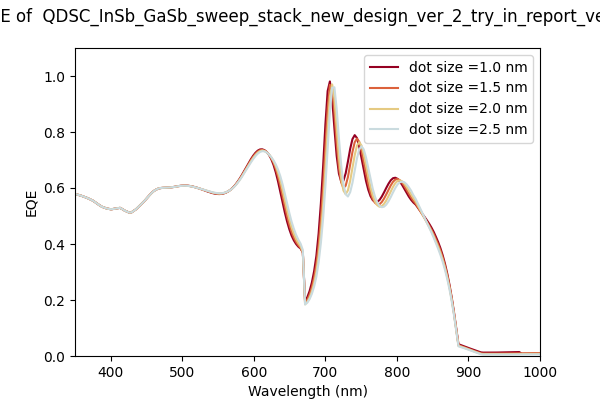

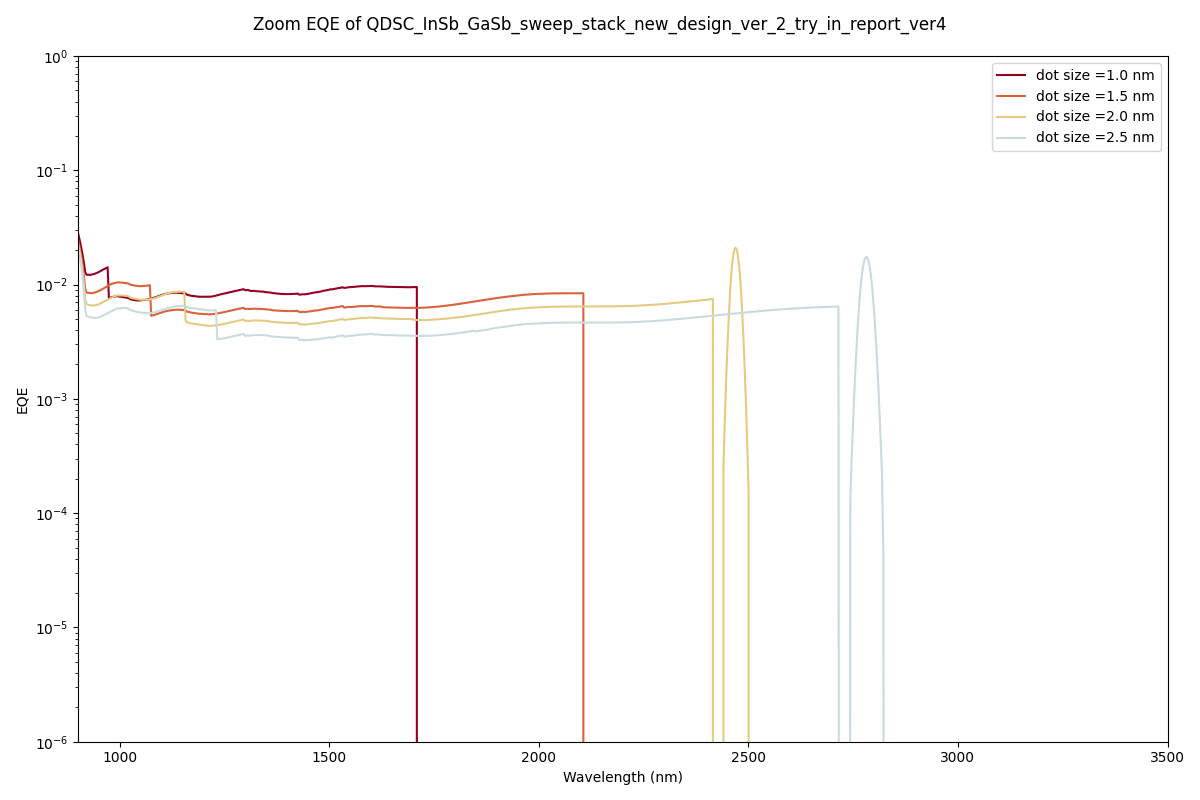

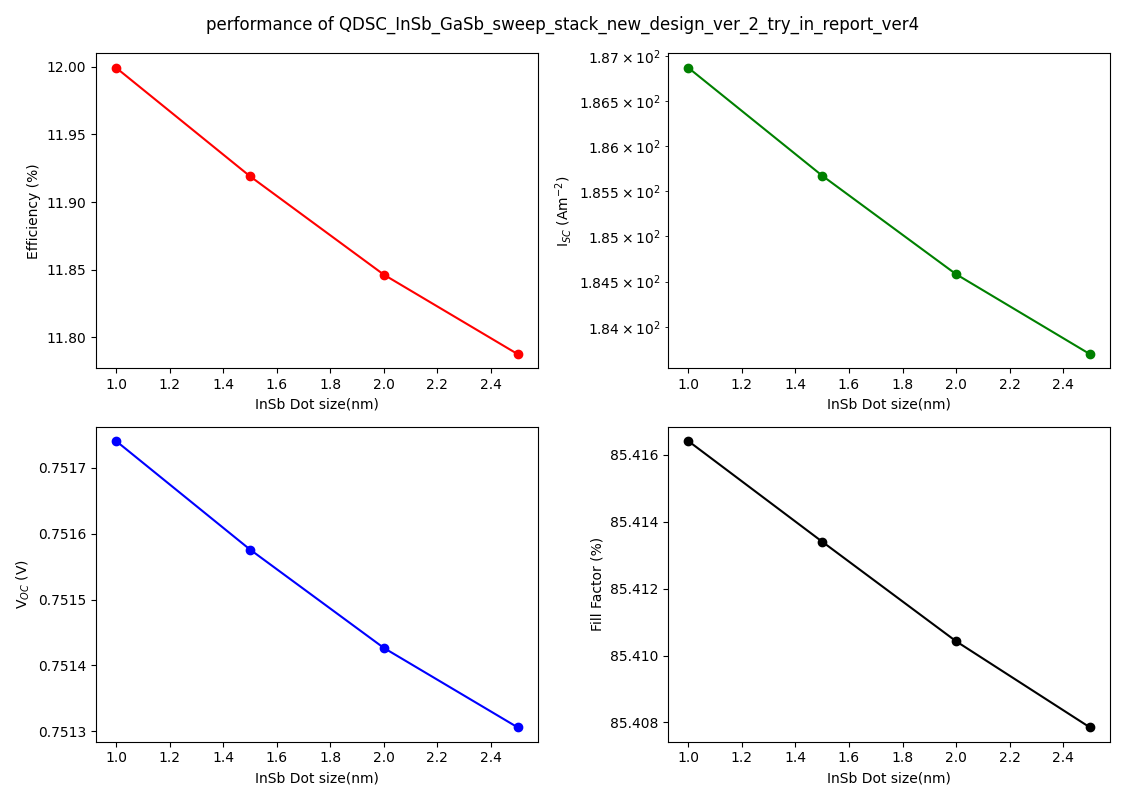

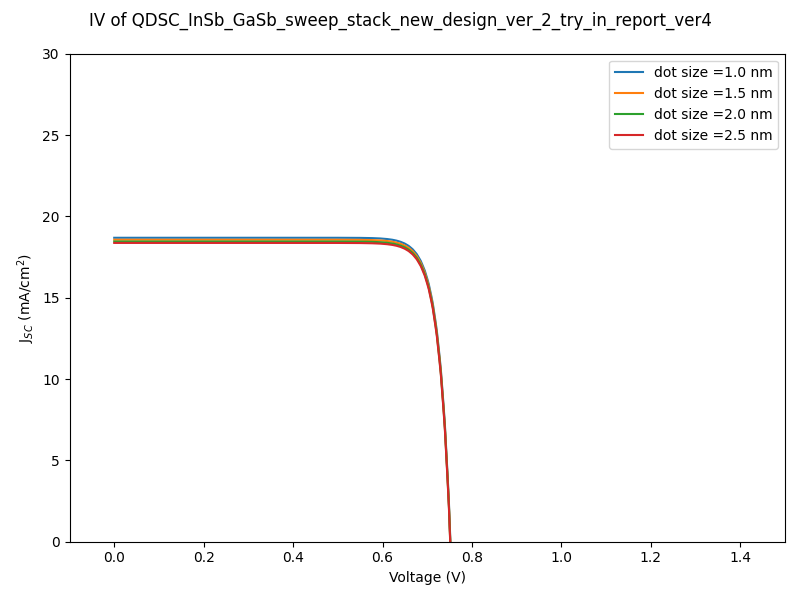

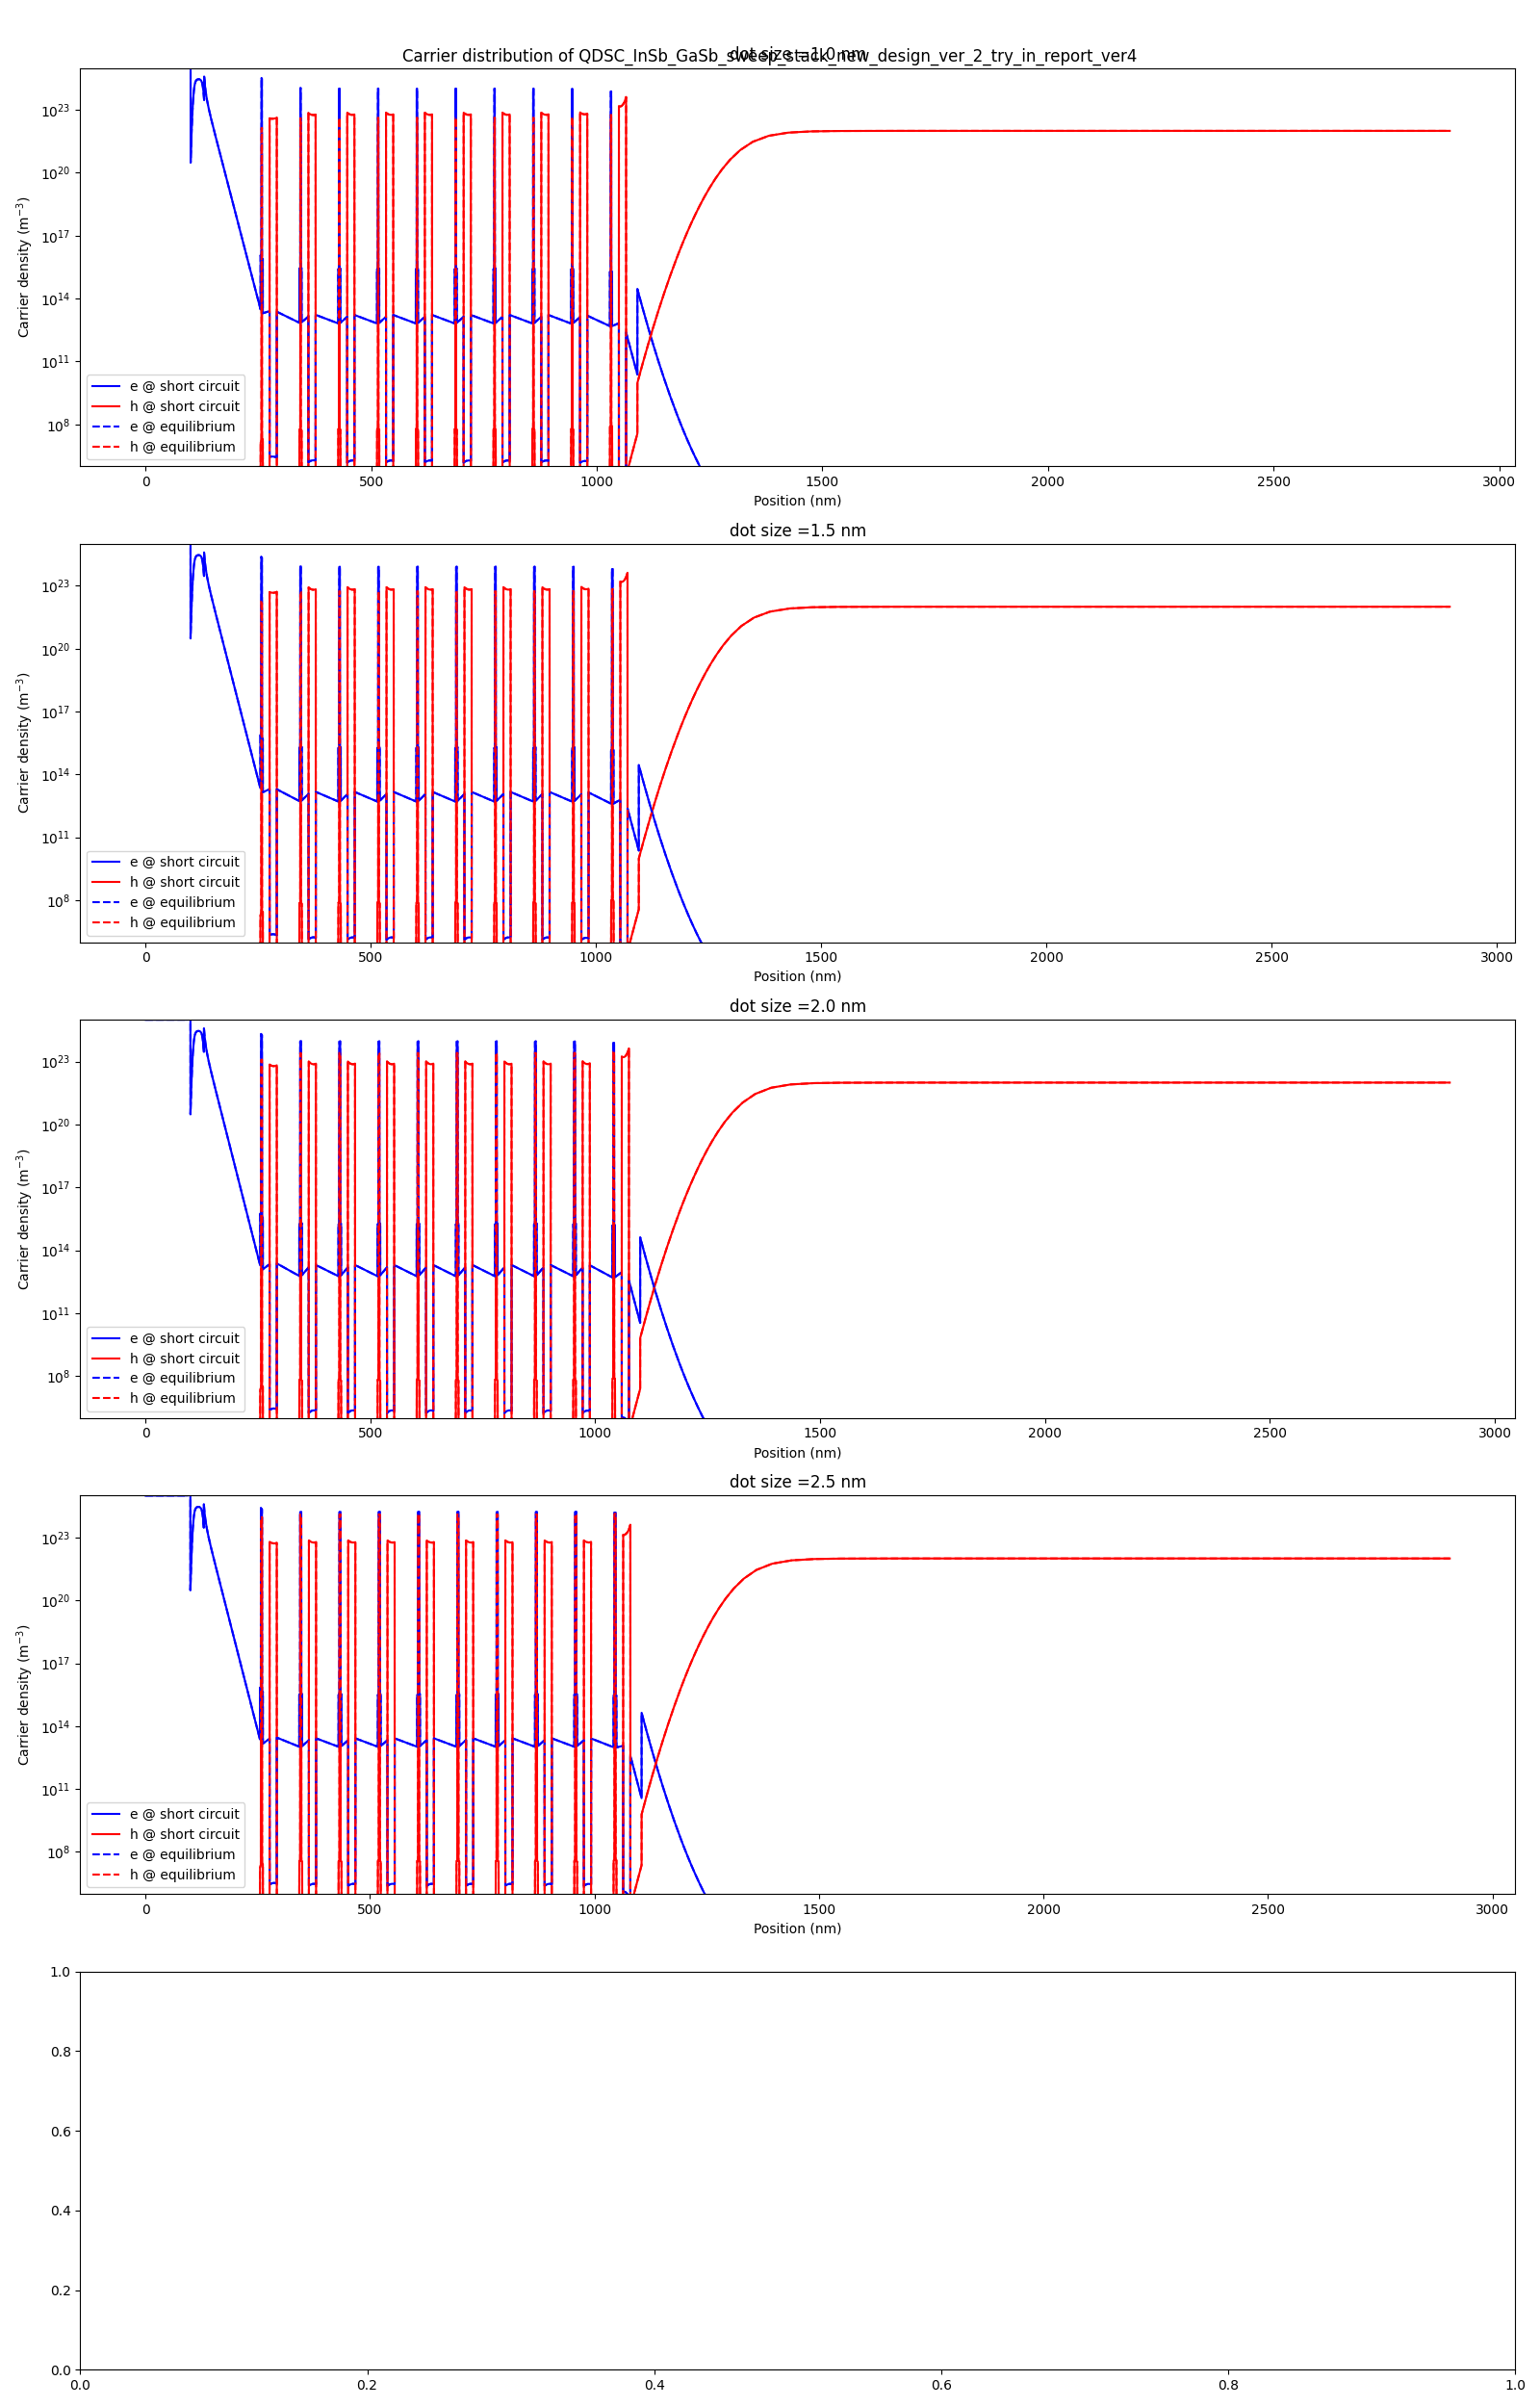

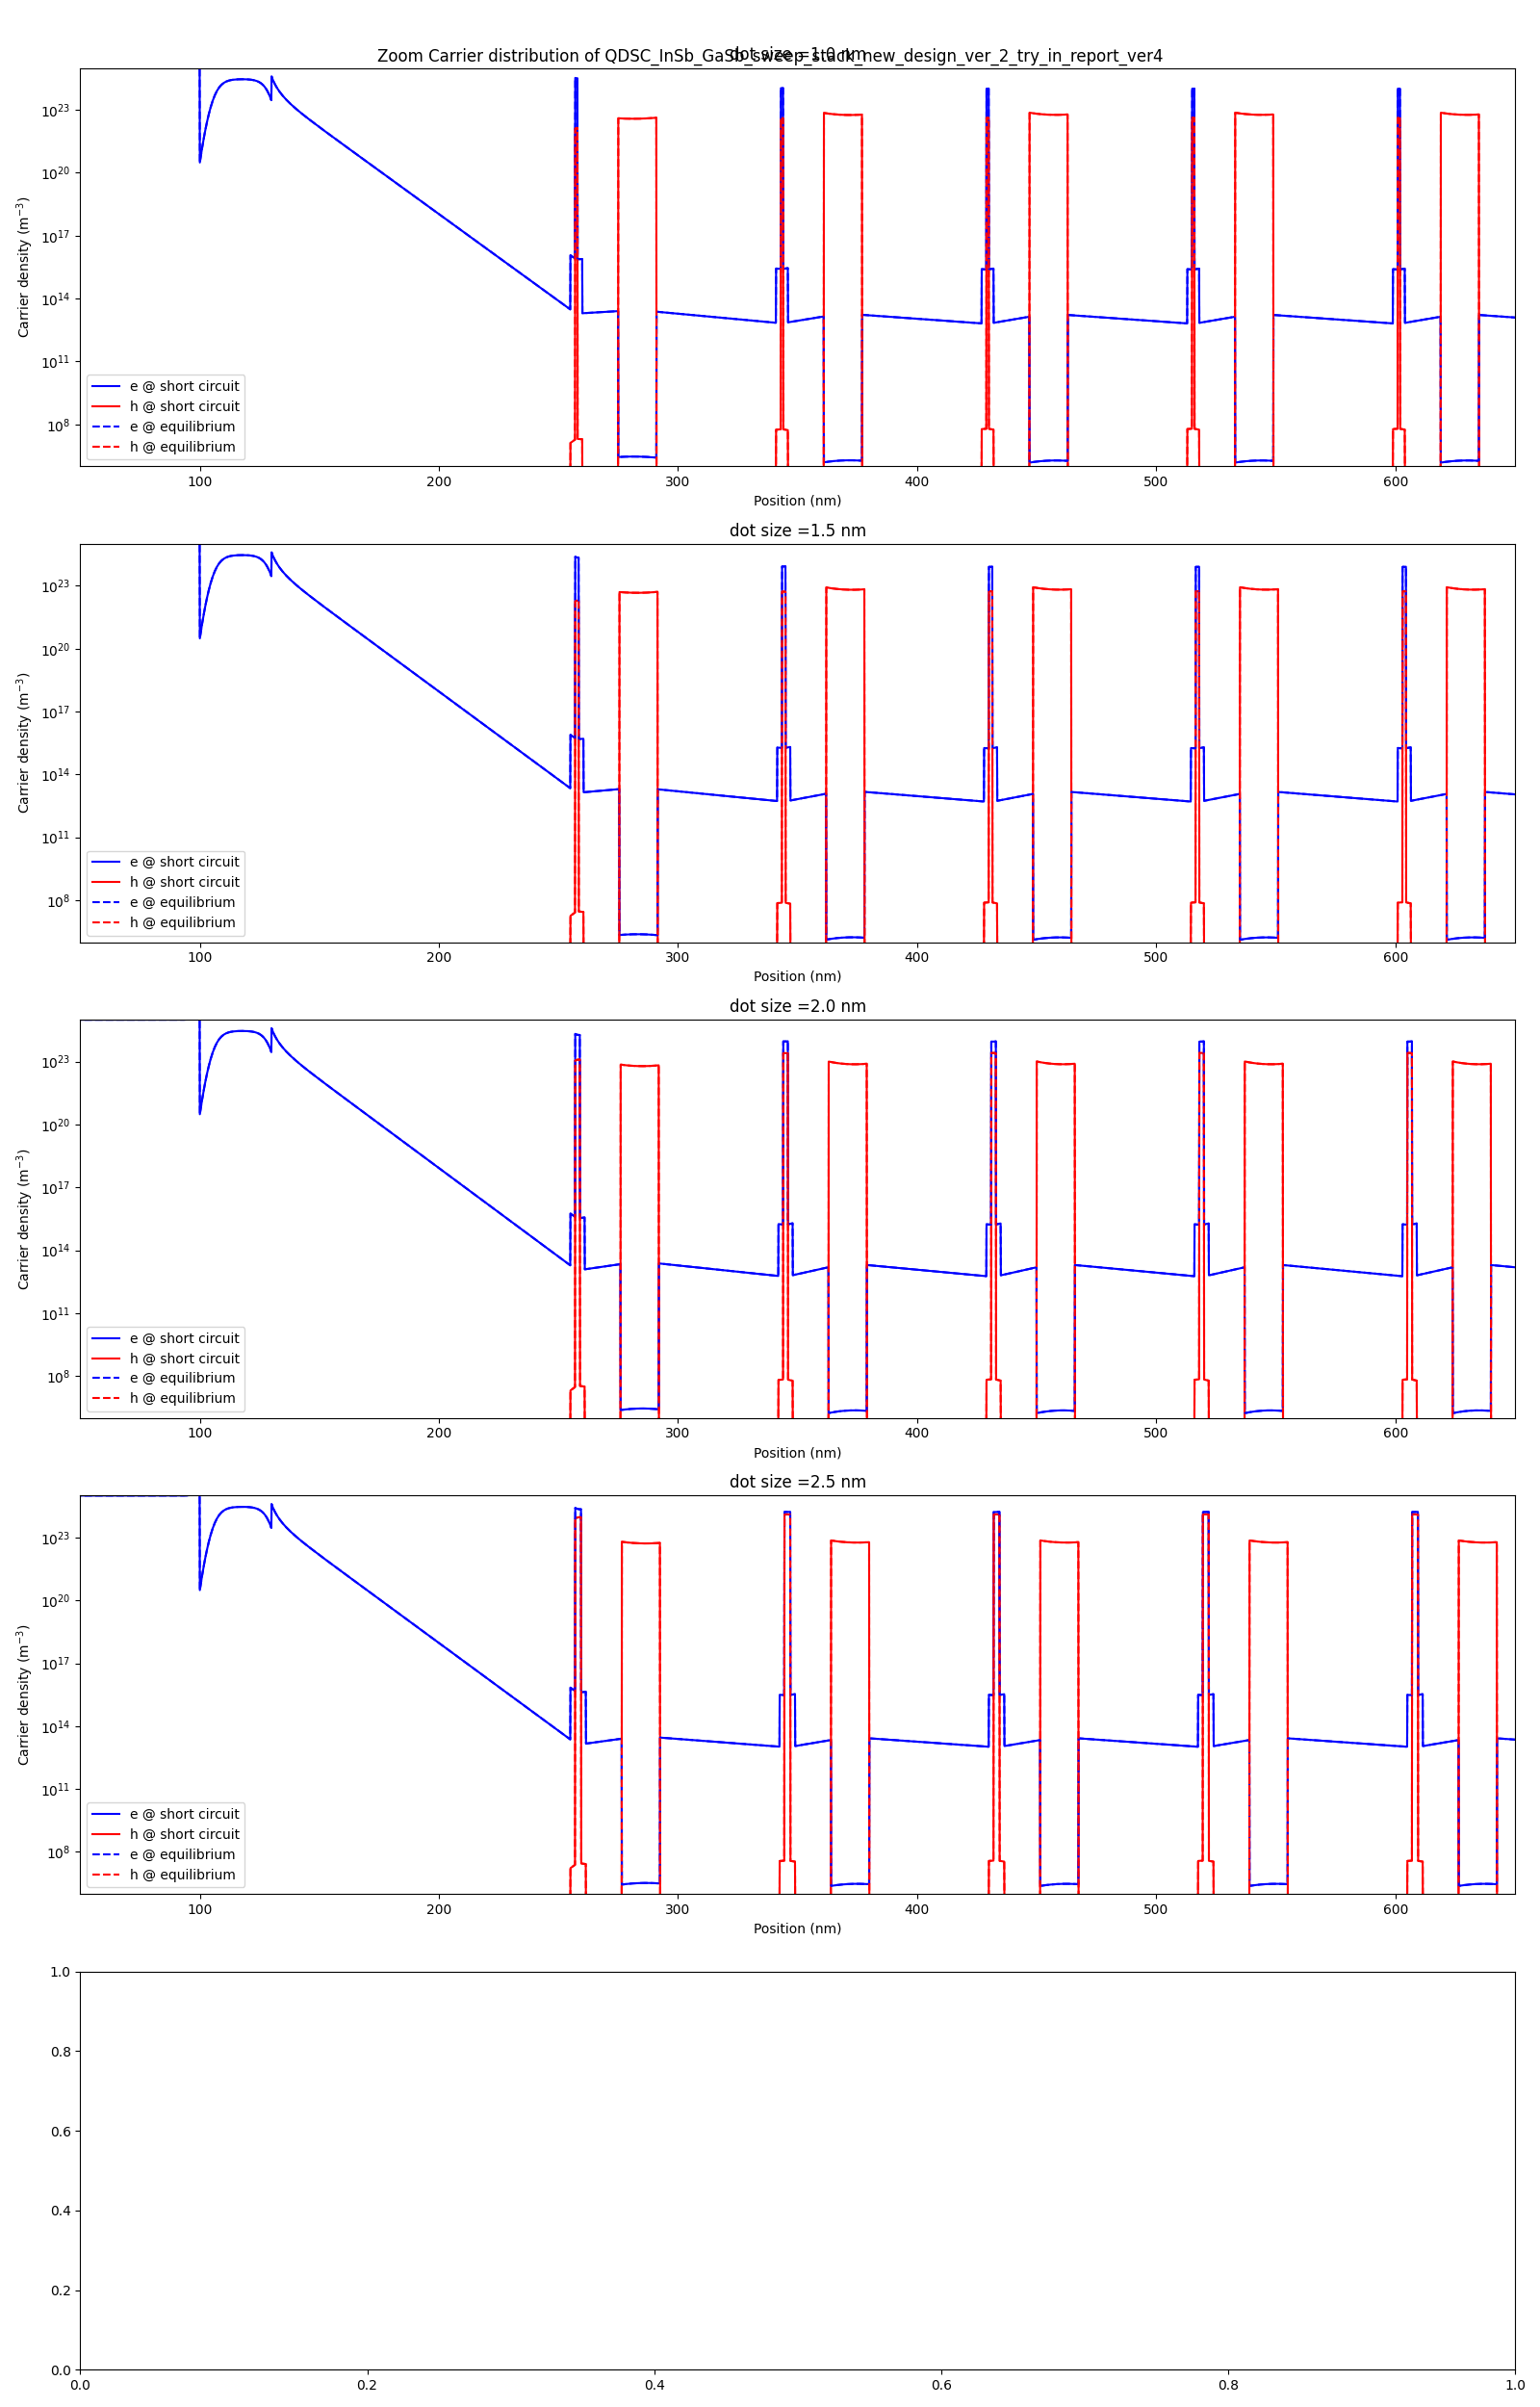

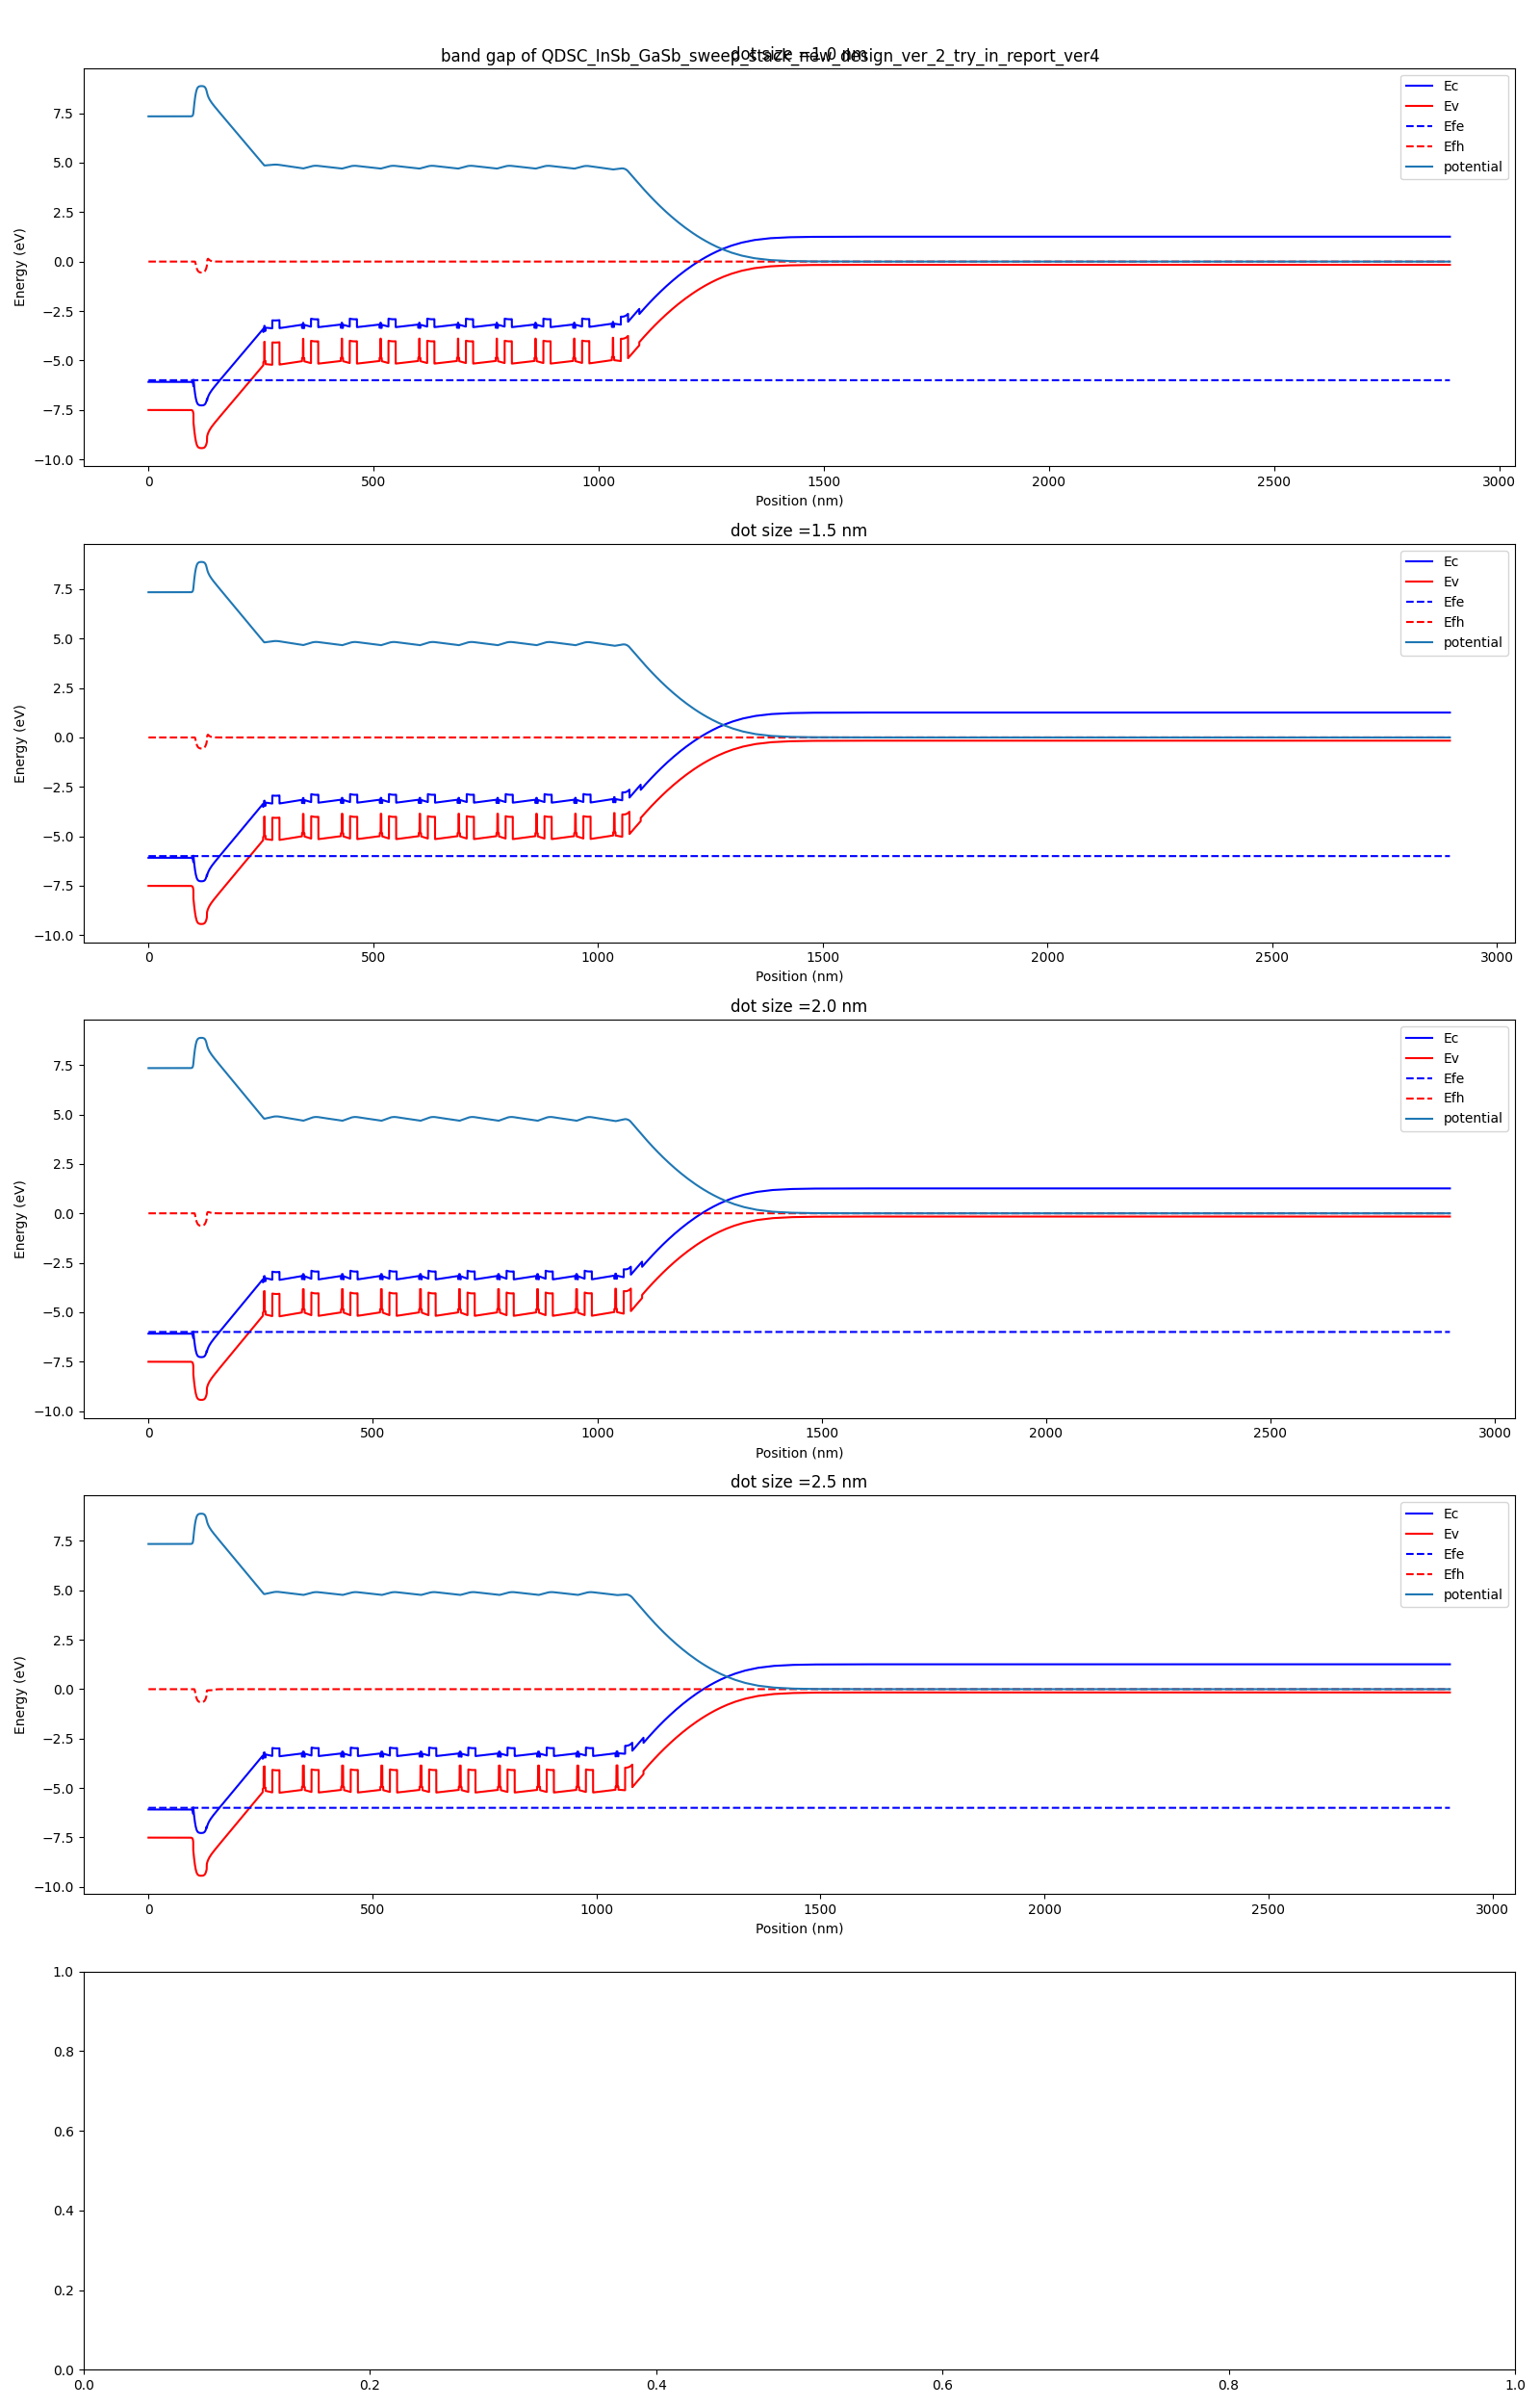

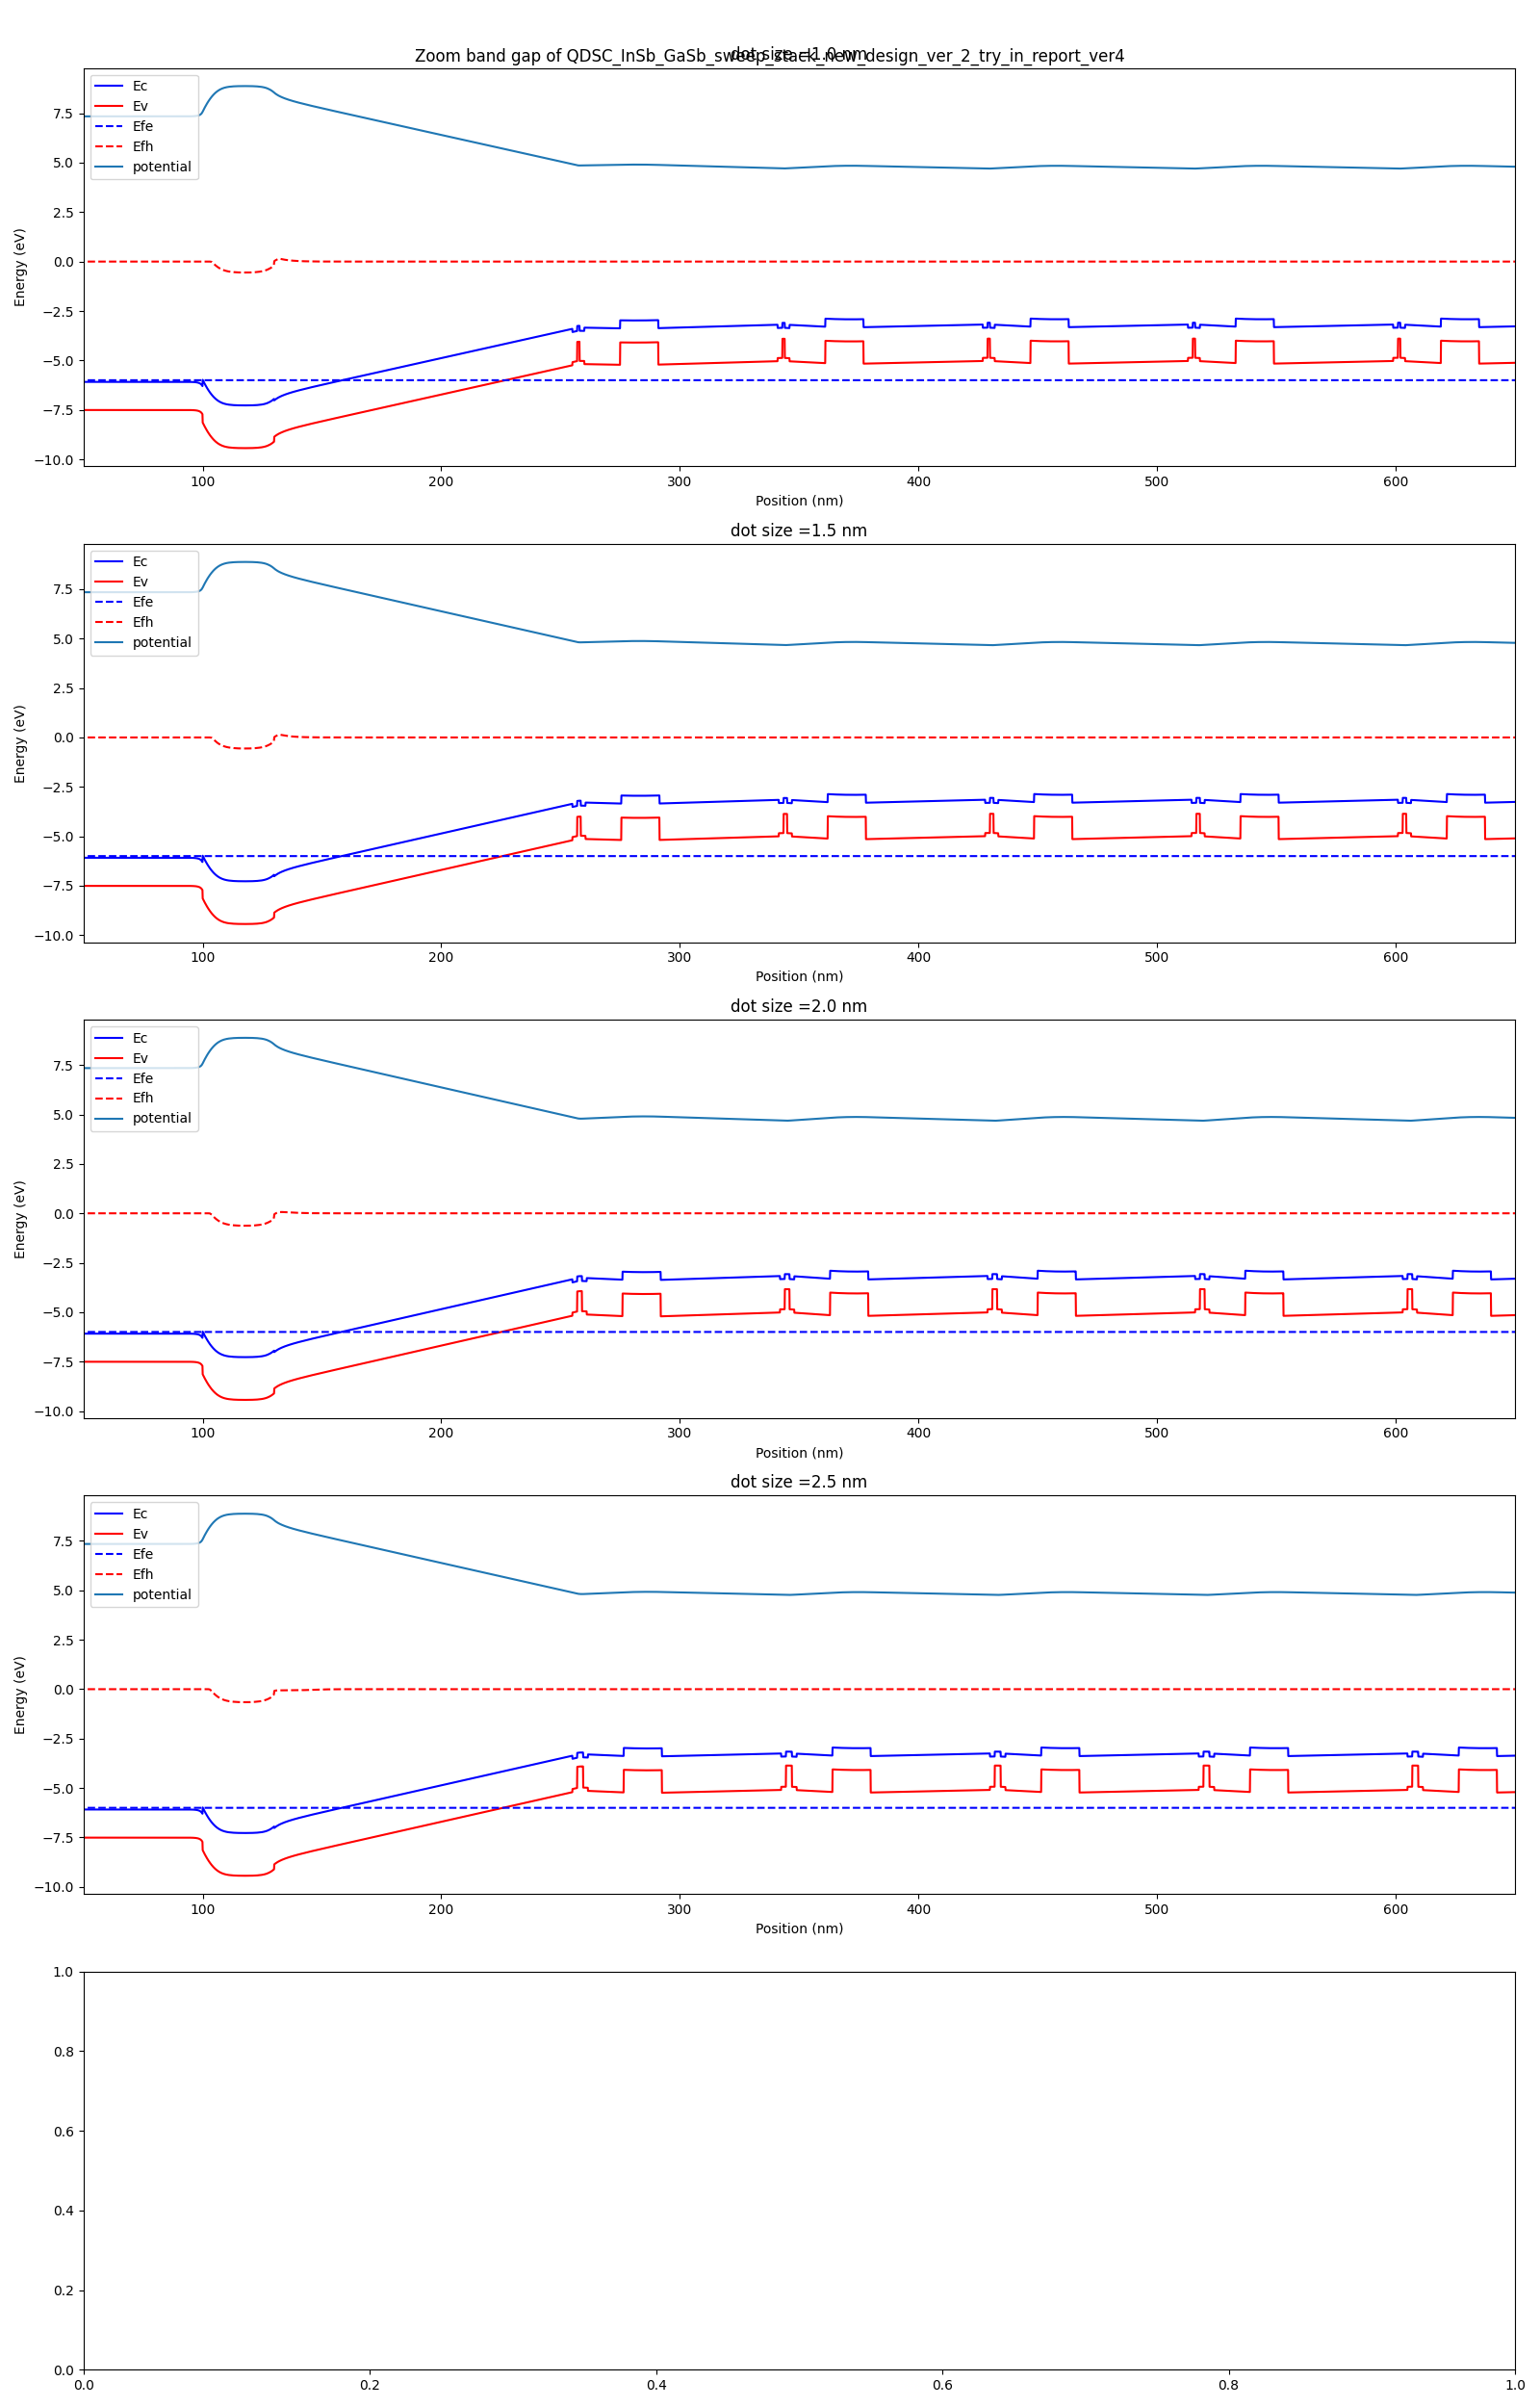

In [2]:
%matplotlib widget
version = "QDSC_InSb_GaSb_sweep_stack_new_design_ver_2_try_in_report_ver4"
sim_mat, plot_note = QDSC_InSb_GaSb_sweep_stack_new_design_ver_2()
note = f"""
   T=300
   vint = np.linspace(-3, 6, 1000)
   wl = np.linspace(350, 3500, 1000) *1e-9   # version1
   V = np.linspace(-1.5, 0, 500)  # np
   recalculate_absorption = False
   meshpoints ={normal_operation.meshpoints}
   growth_rate = {normal_operation.growth_rate}
   coarse = {normal_operation.coarse}
   fine = {normal_operation.fine}
   ultrafine = {normal_operation.ultrafine}

   clamp = {normal_operation.clamp}
   nitermax = {normal_operation.nitermax}
   ATol = {normal_operation.ATol}
   RTol = {normal_operation.RTol}

   srh = {normal_operation.srh}
   rad = {normal_operation.rad}
   aug = {normal_operation.aug}
   sur = {normal_operation.sur}
   gen = {normal_operation.gen}

   recalculate_absorption = {normal_operation.recalculate_absorption}
   radiative_coupling: False
   optics_method: "TMM",
   """
sim1D_sun_constant(version, sim_mat, plot_note, note, pdd_options=normal_operation)

In [ ]:
version = "QDSC_InSb_GaSb_sweep_stack_AlGaAs_try_in_report"
set_of_data_sun_constant = load_old_data('QDSC_InSb_GaSb_sweep_stack_AlGaAs_try_in_report.pkl')
# for i in set_of_data_sun_constant:
#     print(i)
# print(len(set_of_data_sun_constant))
# print(len(set_of_data_sun_constant))
save_set_of_data_sun_constant(set_of_data_sun_constant, version, focus_area=(300, 3500))
try:
    movefile(f'Carrier_distribution_{version}.html', f'{version}')
    movefile(f'Carrier_distribution_{version}_zoom.html', f'{version}')
    movefile(f'Band_diagramming_of_{version}.html', f'{version}')
    movefile(f'Band_diagramming_of_{version}_zoom.html', f'{version}')
except PermissionError as e:
    print(f"Error: {e}")